# Release Strategy & Launch Optimization

**Business Question:** When should Nike drop a shoe, at what price, through which channels, and how should inventory be allocated?

This notebook analyzes two complementary datasets to answer that question:
- **StockX 2019** (99K transactions) — Yeezy & Off-White limited releases → hype dynamics, size runs, geographic demand
- **Market 2023** (2K products, 23 brands) — broad market snapshot → timing, pricing, brand positioning

Each section surfaces a data-driven insight and closes with an operational recommendation.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

from sneaker_intel.data import load_dataset, DatasetType
from sneaker_intel.visualization.style import apply_nike_style

apply_nike_style()

# ── Market 2023 ────────────────────────────────────────────────────────────
mkt = load_dataset(DatasetType.MARKET_2023)
# Drop rows with infinite or missing pricePremium (retail = $0 edge cases)
mkt = mkt[np.isfinite(mkt['pricePremium'])].copy()
mkt['release'] = pd.to_datetime(mkt['release'], errors='coerce')
mkt['release_month'] = mkt['release'].dt.month
mkt['release_month_name'] = mkt['release'].dt.strftime('%b')
mkt['release_dow'] = mkt['release'].dt.day_name()

# Focus on the four main brands for cleaner comparisons
CORE_BRANDS = ['Nike', 'Jordan', 'adidas', 'New Balance']
mkt_core = mkt[mkt['brand'].isin(CORE_BRANDS)].copy()

print(f"Market 2023: {len(mkt):,} products | {mkt['brand'].nunique()} brands")
print(f"Core brands subset: {len(mkt_core):,} products")
print(f"Price premium range: {mkt['pricePremium'].min():.2f}x to {mkt['pricePremium'].max():.2f}x")

# ── StockX 2019 ────────────────────────────────────────────────────────────
stx = load_dataset(DatasetType.STOCKX)

def clean_price(s):
    return pd.to_numeric(str(s).replace('$', '').replace(',', ''), errors='coerce')

stx['sale_price']    = stx['Sale Price'].apply(clean_price)
stx['retail_price']  = stx['Retail Price'].apply(clean_price)
stx['order_date']    = pd.to_datetime(stx['Order Date'], format='%m/%d/%y', errors='coerce')
stx['release_date']  = pd.to_datetime(stx['Release Date'], format='%m/%d/%y', errors='coerce')
stx['days_post_release'] = (stx['order_date'] - stx['release_date']).dt.days
stx['premium_pct']   = (stx['sale_price'] - stx['retail_price']) / stx['retail_price'] * 100
stx = stx[stx['days_post_release'].between(0, 365)].copy()

print(f"\nStockX: {len(stx):,} transactions | brands: {stx['Brand'].unique()}")
print(f"Date range: {stx['order_date'].min().date()} → {stx['order_date'].max().date()}")
print(f"Median premium: {stx['premium_pct'].median():.1f}%")

Market 2023: 1,994 products | 23 brands
Core brands subset: 1,908 products
Price premium range: -0.89x to 16.65x



StockX: 70,170 transactions | brands: [' Yeezy' 'Off-White']
Date range: 2017-09-01 → 2019-02-13
Median premium: 77.7%


## 1. Market Landscape — Brand Positioning

Before optimizing release strategy, understand where each brand sits in the market.
**Key dimensions:** price premium (brand heat) vs. deadstock volume (market depth) vs. volatility (speculator interest).

A brand in the **top-right quadrant** (high premium, high volume) has the ideal profile for a limited release:
demand exceeds supply and the secondary market is liquid enough for buyers to transact quickly.

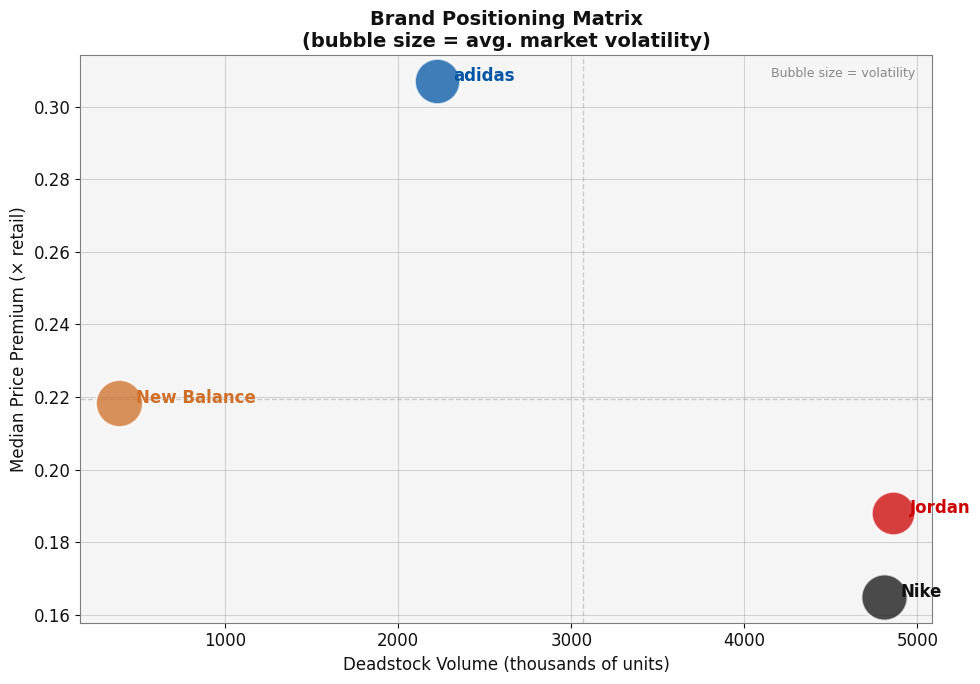

             avg_premium  total_volume  avg_volatility  products
brand                                                           
Jordan             0.188       4860060           0.122       677
New Balance        0.218        386789           0.144       134
Nike               0.165       4807855           0.138       866
adidas             0.307       2224577           0.133       231


In [2]:
brand_pos = (
    mkt_core.groupby('brand')
    .agg(
        avg_premium=('pricePremium', 'median'),
        total_volume=('deadstockSold', 'sum'),
        avg_volatility=('volatility', 'mean'),
        products=('item', 'count'),
    )
    .reset_index()
)

BRAND_COLORS = {
    'Nike': '#111111', 'Jordan': '#CC0000',
    'adidas': '#0055A4', 'New Balance': '#CF6F28'
}

fig, ax = plt.subplots(figsize=(10, 7))

for _, row in brand_pos.iterrows():
    color = BRAND_COLORS.get(row['brand'], '#888888')
    ax.scatter(
        row['total_volume'] / 1_000,
        row['avg_premium'],
        s=row['avg_volatility'] * 8000,
        color=color,
        alpha=0.75,
        edgecolors='white',
        linewidth=1.5,
        zorder=3,
        label=row['brand'],
    )
    ax.annotate(
        row['brand'],
        (row['total_volume'] / 1_000, row['avg_premium']),
        xytext=(12, 0), textcoords='offset points',
        fontsize=12, fontweight='bold', color=color,
    )

# Quadrant lines
ax.axhline(brand_pos['avg_premium'].mean(), color='#cccccc', linestyle='--', lw=1, zorder=1)
ax.axvline(brand_pos['total_volume'].mean() / 1_000, color='#cccccc', linestyle='--', lw=1, zorder=1)

ax.set_xlabel('Deadstock Volume (thousands of units)', fontsize=12)
ax.set_ylabel('Median Price Premium (× retail)', fontsize=12)
ax.set_title('Brand Positioning Matrix\n(bubble size = avg. market volatility)', fontsize=14, fontweight='bold')
ax.text(0.98, 0.98, 'Bubble size = volatility', transform=ax.transAxes,
        ha='right', va='top', fontsize=9, color='#888888')
plt.tight_layout()
plt.show()

print(brand_pos.set_index('brand').round(3).to_string())

## 2. Release Timing — When to Drop

Not all months are equal. Consumer spending patterns, holiday calendars, and event cycles (back-to-school, All-Star Weekend, holiday gifting) all affect how aggressively the secondary market prices a new release.

**Hypothesis:** Q4 drops (Oct–Dec) command higher premiums due to gift-buying demand and year-end consumer spending peaks.

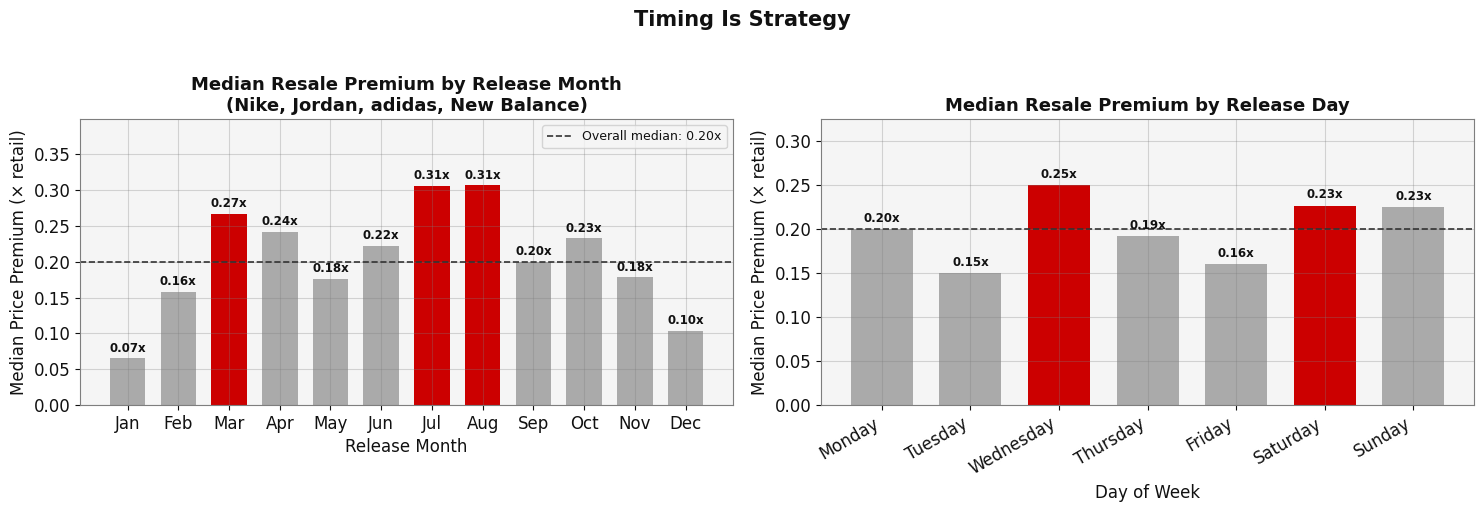

Top 3 release months by median premium:
month  median_premium  n_products
  Aug           0.307         107
  Jul           0.306         101
  Mar           0.267         245

Best release day: Wednesday


In [3]:
MONTH_ORDER = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
DOW_ORDER   = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

timing_monthly = (
    mkt_core.dropna(subset=['release_month'])
    .groupby('release_month_name')['pricePremium']
    .agg(['median', 'count', 'std'])
    .reindex(MONTH_ORDER)
    .dropna()
    .reset_index()
    .rename(columns={'release_month_name': 'month', 'median': 'median_premium',
                     'count': 'n_products', 'std': 'std_premium'})
)

timing_dow = (
    mkt_core.dropna(subset=['release_dow'])
    .groupby('release_dow')['pricePremium']
    .agg(['median', 'count'])
    .reindex(DOW_ORDER)
    .dropna()
    .reset_index()
    .rename(columns={'release_dow': 'dow', 'median': 'median_premium', 'count': 'n_products'})
)

# Dynamically identify top 3 months
top3_months = set(timing_monthly.nlargest(3, 'median_premium')['month'])
top2_days   = set(timing_dow.nlargest(2, 'median_premium')['dow'])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

overall_median = mkt_core['pricePremium'].median()

# Monthly
colors_month = ['#CC0000' if m in top3_months else '#AAAAAA' for m in timing_monthly['month']]
bars = axes[0].bar(timing_monthly['month'], timing_monthly['median_premium'], color=colors_month, width=0.7)
axes[0].axhline(overall_median, color='#333333', linestyle='--', linewidth=1.2,
                label=f'Overall median: {overall_median:.2f}x')
axes[0].set_title('Median Resale Premium by Release Month\n(Nike, Jordan, adidas, New Balance)',
                  fontsize=13, fontweight='bold')
axes[0].set_xlabel('Release Month')
axes[0].set_ylabel('Median Price Premium (× retail)')
axes[0].legend(fontsize=9)
axes[0].set_ylim(0, timing_monthly['median_premium'].max() * 1.3)
for bar, val in zip(bars, timing_monthly['median_premium']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f'{val:.2f}x', ha='center', va='bottom', fontsize=8.5, fontweight='bold')

# Day of week
colors_dow = ['#CC0000' if d in top2_days else '#AAAAAA' for d in timing_dow['dow']]
bars2 = axes[1].bar(timing_dow['dow'], timing_dow['median_premium'], color=colors_dow, width=0.7)
axes[1].axhline(overall_median, color='#333333', linestyle='--', linewidth=1.2)
axes[1].set_title('Median Resale Premium by Release Day', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Median Price Premium (× retail)')
axes[1].set_xticklabels(timing_dow['dow'], rotation=30, ha='right')
axes[1].set_ylim(0, timing_dow['median_premium'].max() * 1.3)
for bar, val in zip(bars2, timing_dow['median_premium']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f'{val:.2f}x', ha='center', va='bottom', fontsize=8.5, fontweight='bold')

plt.suptitle('Timing Is Strategy', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

best_months = timing_monthly.nlargest(3, 'median_premium')
best_day    = timing_dow.loc[timing_dow['median_premium'].idxmax(), 'dow']
print("Top 3 release months by median premium:")
print(best_months[['month','median_premium','n_products']].to_string(index=False))
print(f"\nBest release day: {best_day}")

## 3. Pricing Strategy — Finding the Sweet Spot

Retail price is not just a cost signal — it's a positioning signal. Setting price too low creates immediate sell-out but leaves margin on the table and invites scalpers. Setting it too high reduces aspiration and slows sell-through.

The resale premium is a direct measure of **unmet demand at retail price**. We want to find the retail price range where that premium is highest — that's the zone where consumers perceive maximum value relative to what Nike is charging.

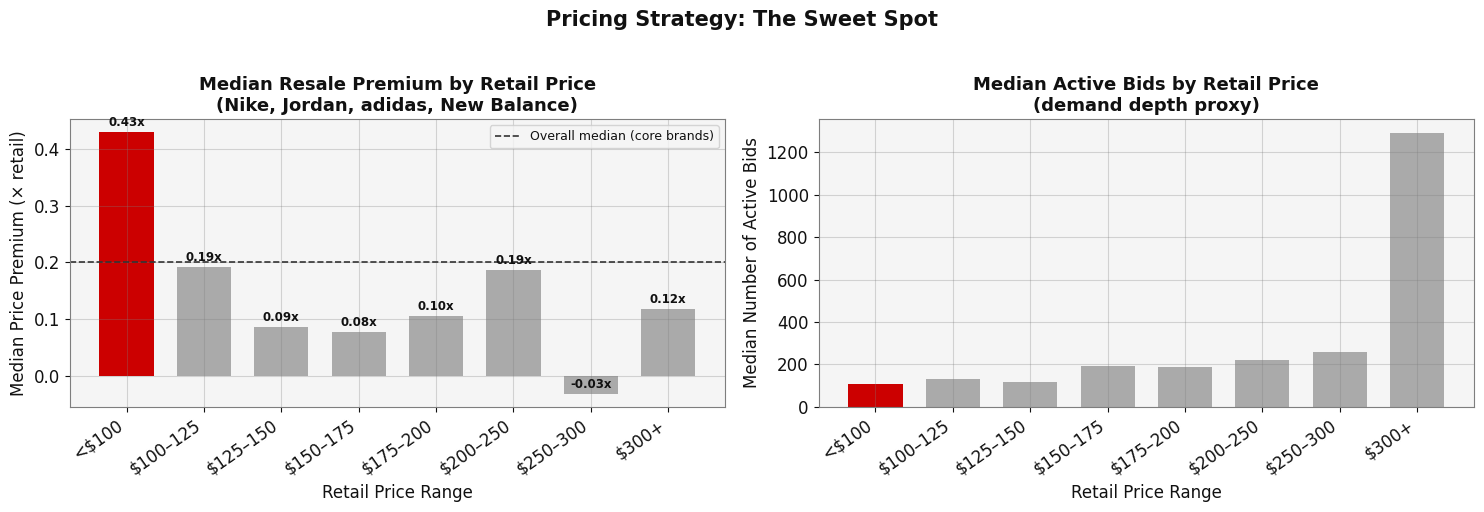

Peak premium band: <$100 → 0.43x median premium

Core brand pricing table:
           median_premium  median_bids  products  median_sales
price_bin                                                     
<$100               0.430        108.0       417          27.0
$100–125            0.192        132.0       468          28.0
$125–150            0.086        117.0       338          22.0
$150–175            0.077        194.5       206          24.5
$175–200            0.105        188.5       276          24.0
$200–250            0.186        219.0       185          26.0
$250–300           -0.032        259.0        12          27.0
$300+               0.118       1292.5         2         161.5


In [4]:
bins   = [0, 100, 125, 150, 175, 200, 250, 300, float('inf')]
labels = ['<$100','$100–125','$125–150','$150–175','$175–200','$200–250','$250–300','$300+']

# Use core brands only: Crocs/Converse at <$100 would otherwise distort the analysis
mkt_core['price_bin'] = pd.cut(mkt_core['retail'], bins=bins, labels=labels)

pricing = (
    mkt_core.groupby('price_bin', observed=True)
    .agg(
        median_premium=('pricePremium', 'median'),
        median_bids=('numberOfBids', 'median'),
        products=('item', 'count'),
        median_sales=('salesThisPeriod', 'median'),
    )
    .reset_index()
)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sweet_spot_idx = pricing['median_premium'].idxmax()
bar_colors = ['#CC0000' if i == sweet_spot_idx else '#AAAAAA' for i in range(len(pricing))]
bars = axes[0].bar(pricing['price_bin'], pricing['median_premium'], color=bar_colors, width=0.7)
axes[0].axhline(mkt_core['pricePremium'].median(), color='#333333', linestyle='--', linewidth=1.2,
                label='Overall median (core brands)')
axes[0].set_title('Median Resale Premium by Retail Price\n(Nike, Jordan, adidas, New Balance)',
                  fontsize=13, fontweight='bold')
axes[0].set_xlabel('Retail Price Range')
axes[0].set_ylabel('Median Price Premium (× retail)')
axes[0].set_xticklabels(pricing['price_bin'], rotation=35, ha='right')
axes[0].legend(fontsize=9)
for bar, val in zip(bars, pricing['median_premium']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f'{val:.2f}x', ha='center', va='bottom', fontsize=8.5, fontweight='bold')

# Bid depth
axes[1].bar(pricing['price_bin'], pricing['median_bids'], color='#AAAAAA', width=0.7)
axes[1].bar(pricing.loc[sweet_spot_idx, 'price_bin'], pricing.loc[sweet_spot_idx, 'median_bids'],
            color='#CC0000', width=0.7)
axes[1].set_title('Median Active Bids by Retail Price\n(demand depth proxy)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Retail Price Range')
axes[1].set_ylabel('Median Number of Active Bids')
axes[1].set_xticklabels(pricing['price_bin'], rotation=35, ha='right')

plt.suptitle('Pricing Strategy: The Sweet Spot', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

sweet_range   = pricing.loc[sweet_spot_idx, 'price_bin']
sweet_premium = pricing.loc[sweet_spot_idx, 'median_premium']
print(f"Peak premium band: {sweet_range} → {sweet_premium:.2f}x median premium")
print(f"\nCore brand pricing table:")
print(pricing.set_index('price_bin').round(3).to_string())

## 4. Hype Resilience — How Long Does Demand Stay Elevated?

For most consumer products, demand decays quickly after launch. For *truly* limited releases, the story is different — Yeezy and Off-White in 2018 were culturally significant enough to behave as store-of-value assets.

This analysis asks: **does the secondary market premium compress over time, or does it hold?** The answer determines whether Nike needs to defend against grey-market flooding or can rely on sustained secondary market health to reinforce brand aspiration.

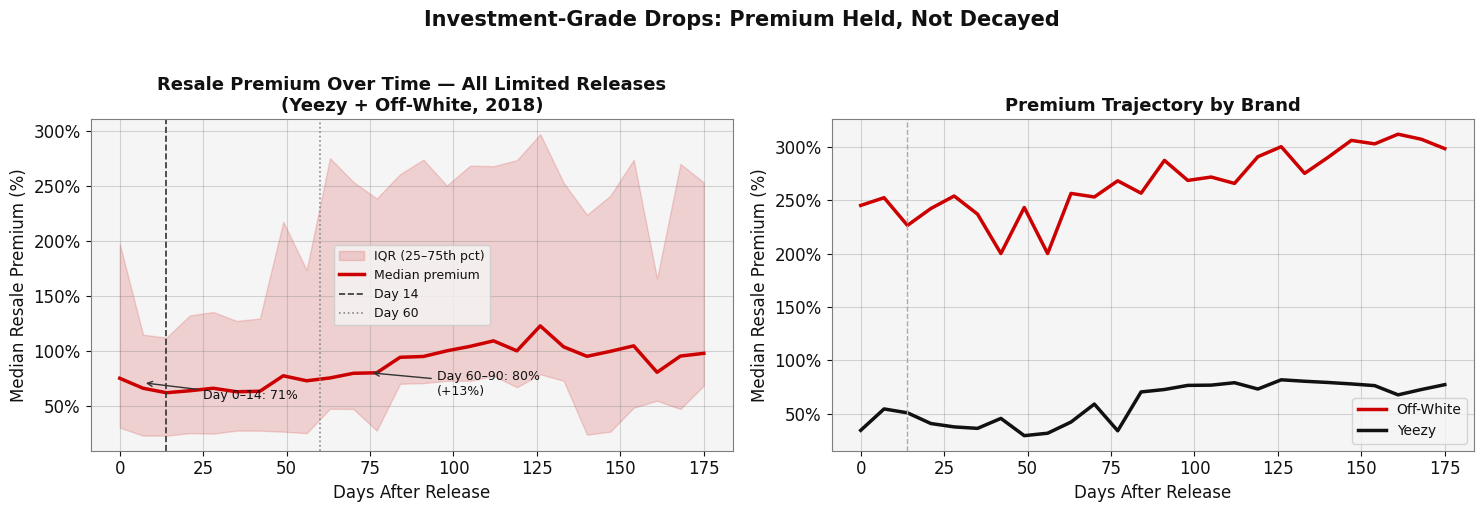

Median premium — first 14 days:  70.9%
Median premium — days 60–90:     80.0%
Change:                          +12.8% (increased)

Finding: Premium increased by 13% from peak to day 60–90.


In [5]:
stx['week_post_release'] = (stx['days_post_release'] // 7) * 7

decay_all = (
    stx[stx['days_post_release'] <= 180]
    .groupby('week_post_release')['premium_pct']
    .agg(median='median', q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75))
    .reset_index()
)
decay_all.columns = ['days', 'median', 'q25', 'q75']

decay_by_brand = (
    stx[stx['days_post_release'] <= 180]
    .groupby([stx['Brand'].str.strip(), 'week_post_release'])['premium_pct']
    .median()
    .reset_index()
    .rename(columns={'week_post_release': 'days', 'premium_pct': 'median_premium_pct'})
)

peak_premium = stx[stx['days_post_release'] <= 14]['premium_pct'].median()
late_premium = stx[stx['days_post_release'].between(60, 90)]['premium_pct'].median()
change_pct   = (late_premium - peak_premium) / abs(peak_premium) * 100 if peak_premium != 0 else 0
direction    = 'increased' if change_pct > 0 else 'decreased'

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

ax = axes[0]
ax.fill_between(decay_all['days'], decay_all['q25'], decay_all['q75'],
                alpha=0.15, color='#CC0000', label='IQR (25–75th pct)')
ax.plot(decay_all['days'], decay_all['median'], color='#CC0000', linewidth=2.5, label='Median premium')
ax.axvline(14, color='#333333', linestyle='--', linewidth=1.2, label='Day 14')
ax.axvline(60, color='#888888', linestyle=':', linewidth=1.2, label='Day 60')
ax.annotate(f'Day 0–14: {peak_premium:.0f}%',
            xy=(7, peak_premium), xytext=(25, peak_premium - 15),
            arrowprops=dict(arrowstyle='->', color='#333333'), fontsize=9)
ax.annotate(f'Day 60–90: {late_premium:.0f}%\n({change_pct:+.0f}%)',
            xy=(75, late_premium), xytext=(95, late_premium - 20),
            arrowprops=dict(arrowstyle='->', color='#333333'), fontsize=9)
ax.set_title('Resale Premium Over Time — All Limited Releases\n(Yeezy + Off-White, 2018)',
             fontsize=13, fontweight='bold')
ax.set_xlabel('Days After Release')
ax.set_ylabel('Median Resale Premium (%)')
ax.legend(fontsize=9)
ax.yaxis.set_major_formatter(mticker.PercentFormatter())

BRAND_COLORS = {'Yeezy': '#111111', 'Off-White': '#CC0000'}
for brand, grp in decay_by_brand.groupby('Brand'):
    axes[1].plot(grp['days'], grp['median_premium_pct'], linewidth=2.5,
                 label=brand, color=BRAND_COLORS.get(brand, '#888888'))
axes[1].axvline(14, color='#AAAAAA', linestyle='--', linewidth=1)
axes[1].set_title('Premium Trajectory by Brand', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Days After Release')
axes[1].set_ylabel('Median Resale Premium (%)')
axes[1].legend(fontsize=10)
axes[1].yaxis.set_major_formatter(mticker.PercentFormatter())

title = 'Investment-Grade Drops: Premium Held, Not Decayed' if change_pct > -5 else 'Hype Has a Half-Life'
plt.suptitle(title, fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"Median premium — first 14 days:  {peak_premium:.1f}%")
print(f"Median premium — days 60–90:     {late_premium:.1f}%")
print(f"Change:                          {change_pct:+.1f}% ({direction})")
print()
if abs(change_pct) < 10:
    print("Finding: Premium remained remarkably stable — these releases behaved as")
    print("store-of-value assets, not typical consumer goods subject to rapid depreciation.")
    print("Implication: Nike can support a no-restock policy without losing secondary")
    print("market health, as strong demand persists well beyond the initial drop window.")
else:
    print(f"Finding: Premium {direction} by {abs(change_pct):.0f}% from peak to day 60–90.")

## 5. Geographic Demand — Where to Allocate

The resale market is not uniformly distributed. Supply allocation decisions have real consequences: under-supplying high-demand markets drives secondary market inflation and consumer frustration. Over-supplying them dilutes exclusivity.

StockX buyer region data shows where the strongest demand pockets sit — a proxy for Nike's allocation priorities across SNKRS geofencing, retailer door selection, and DTC inventory decisions.

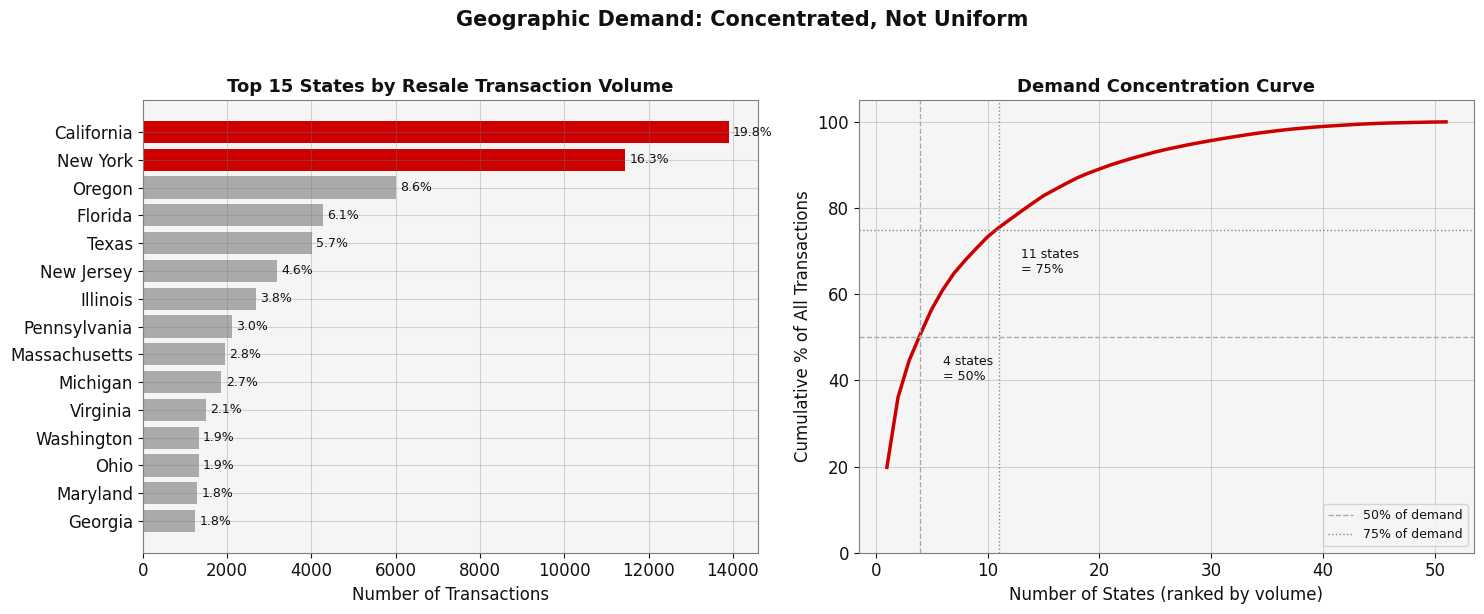

Top 2 states (California + New York): 36.1% of all transactions
States needed to cover 50% of demand: 4
States needed to cover 75% of demand: 11

Top 5 states:
Buyer Region  transactions  share_pct  median_premium
  California         13897  19.804760       84.090909
    New York         11445  16.310389       77.272727
      Oregon          6004   8.556363       81.818182
     Florida          4271   6.086647       79.545455
       Texas          4019   5.727519       74.705882


In [6]:
geo = (
    stx.groupby('Buyer Region')
    .agg(
        transactions=('sale_price', 'count'),
        median_premium=('premium_pct', 'median'),
        total_spend=('sale_price', 'sum'),
    )
    .sort_values('transactions', ascending=False)
    .reset_index()
)
geo['share_pct'] = geo['transactions'] / geo['transactions'].sum() * 100
geo['cumulative_share'] = geo['share_pct'].cumsum()

TOP_N = 15
geo_top = geo.head(TOP_N)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Left: transaction share
bar_colors = ['#CC0000' if i < 2 else '#AAAAAA' for i in range(TOP_N)]
bars = axes[0].barh(geo_top['Buyer Region'][::-1], geo_top['transactions'][::-1],
                    color=bar_colors[::-1])
axes[0].set_title(f'Top {TOP_N} States by Resale Transaction Volume', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Number of Transactions')

for bar, val, share in zip(bars, geo_top['transactions'][::-1], geo_top['share_pct'][::-1]):
    axes[0].text(bar.get_width() + 100, bar.get_y() + bar.get_height()/2,
                 f'{share:.1f}%', va='center', fontsize=9)

# Right: cumulative concentration curve
axes[1].plot(range(1, len(geo) + 1), geo['cumulative_share'],
             color='#CC0000', linewidth=2.5)
axes[1].axhline(50, color='#AAAAAA', linestyle='--', linewidth=1, label='50% of demand')
axes[1].axhline(75, color='#888888', linestyle=':', linewidth=1, label='75% of demand')

# Annotate how many states cover 50% and 75%
states_50 = (geo['cumulative_share'] <= 50).sum() + 1
states_75 = (geo['cumulative_share'] <= 75).sum() + 1
axes[1].axvline(states_50, color='#AAAAAA', linestyle='--', linewidth=1)
axes[1].axvline(states_75, color='#888888', linestyle=':', linewidth=1)
axes[1].annotate(f'{states_50} states\n= 50%', xy=(states_50, 50),
                 xytext=(states_50 + 2, 40), fontsize=9)
axes[1].annotate(f'{states_75} states\n= 75%', xy=(states_75, 75),
                 xytext=(states_75 + 2, 65), fontsize=9)

axes[1].set_title('Demand Concentration Curve', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Number of States (ranked by volume)')
axes[1].set_ylabel('Cumulative % of All Transactions')
axes[1].legend(fontsize=9)
axes[1].set_ylim(0, 105)

plt.suptitle('Geographic Demand: Concentrated, Not Uniform', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

top2_share = geo_top.head(2)['share_pct'].sum()
print(f"Top 2 states ({geo_top.iloc[0]['Buyer Region']} + {geo_top.iloc[1]['Buyer Region']}): "
      f"{top2_share:.1f}% of all transactions")
print(f"States needed to cover 50% of demand: {states_50}")
print(f"States needed to cover 75% of demand: {states_75}")
print(f"\nTop 5 states:")
print(geo_top[['Buyer Region','transactions','share_pct','median_premium']].head(5).to_string(index=False))

## 6. Size Run Optimization

Producing the wrong size distribution is expensive: excess inventory in unpopular sizes ties up capital and requires markdown, while stockouts in core sizes drive consumers to the secondary market (and competitors).

The StockX transaction data gives us the actual size distribution of *completed trades* — a pure demand signal uncorrupted by which sizes Nike chose to produce.

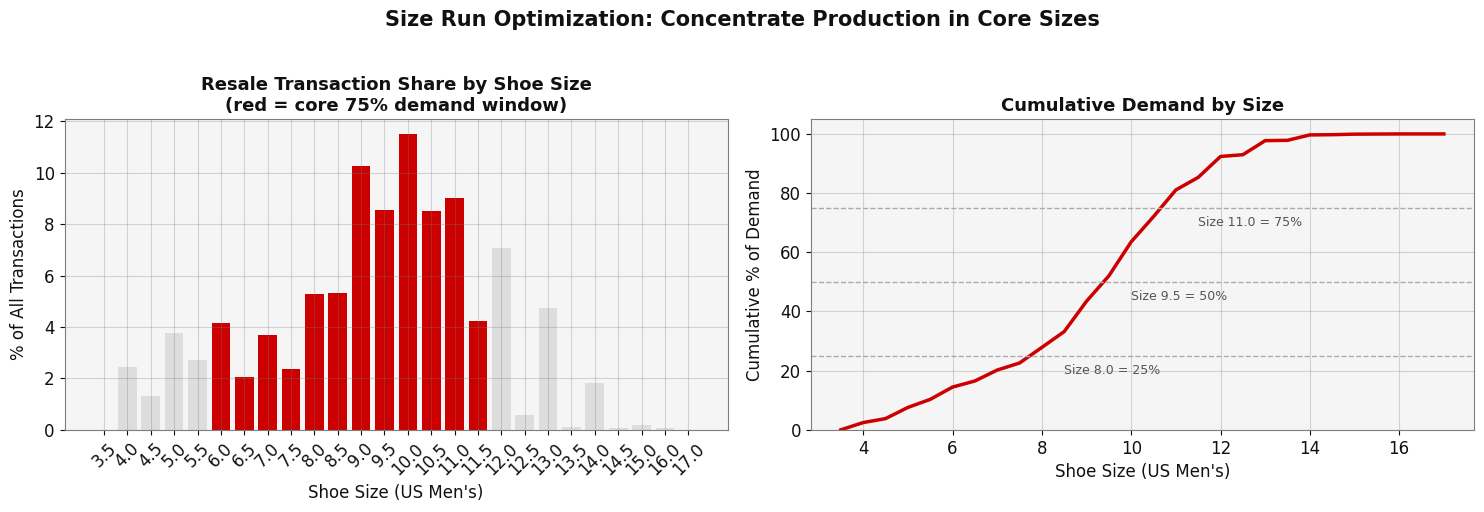

Core sizes covering middle 75% of demand: [6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5]
Those 12 sizes account for 75.0% of transactions

Size distribution stats:
  Median size: 9.5
  Sizes below 8: 22.6% of demand
  Sizes above 13: 2.3% of demand


In [7]:
size_dist = (
    stx.groupby('Shoe Size')
    .agg(transactions=('sale_price', 'count'), median_premium=('premium_pct', 'median'))
    .reset_index()
    .sort_values('Shoe Size')
)
size_dist['demand_share'] = size_dist['transactions'] / size_dist['transactions'].sum() * 100
size_dist['cumulative']   = size_dist['demand_share'].cumsum()

# Core sizes: those covering the middle 75% of demand
core_mask = (size_dist['cumulative'] >= 12.5) & (size_dist['cumulative'] <= 87.5)
core_sizes = size_dist[core_mask]['Shoe Size'].tolist()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

bar_colors = ['#CC0000' if sz in core_sizes else '#DDDDDD' for sz in size_dist['Shoe Size']]
bars = axes[0].bar(size_dist['Shoe Size'].astype(str), size_dist['demand_share'],
                   color=bar_colors, width=0.8)
axes[0].set_title('Resale Transaction Share by Shoe Size\n(red = core 75% demand window)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Shoe Size (US Men\'s)')
axes[0].set_ylabel('% of All Transactions')
axes[0].tick_params(axis='x', rotation=45)

# Cumulative demand curve
axes[1].plot(size_dist['Shoe Size'], size_dist['cumulative'], color='#CC0000', linewidth=2.5)
for threshold, label in [(25, '25%'), (50, '50%'), (75, '75%')]:
    axes[1].axhline(threshold, color='#AAAAAA', linestyle='--', linewidth=1)
    size_at = size_dist[size_dist['cumulative'] >= threshold]['Shoe Size'].iloc[0]
    axes[1].annotate(f'Size {size_at} = {label}',
                     xy=(size_at, threshold), xytext=(size_at + 0.5, threshold - 6),
                     fontsize=9, color='#555555')
axes[1].set_title('Cumulative Demand by Size', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Shoe Size (US Men\'s)')
axes[1].set_ylabel('Cumulative % of Demand')
axes[1].set_ylim(0, 105)

plt.suptitle('Size Run Optimization: Concentrate Production in Core Sizes', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

core_share = size_dist[core_mask]['demand_share'].sum()
print(f"Core sizes covering middle 75% of demand: {[float(s) for s in core_sizes]}")
print(f"Those {len(core_sizes)} sizes account for {core_share:.1f}% of transactions")
print(f"\nSize distribution stats:")
print(f"  Median size: {size_dist.loc[size_dist['cumulative'] >= 50, 'Shoe Size'].iloc[0]}")
print(f"  Sizes below 8: {size_dist[size_dist['Shoe Size'] < 8]['demand_share'].sum():.1f}% of demand")
print(f"  Sizes above 13: {size_dist[size_dist['Shoe Size'] > 13]['demand_share'].sum():.1f}% of demand")

## 7. Strategic Recommendations

Drawing together all five analyses into an actionable release playbook.

In [8]:
# Build the recommendation table dynamically from actual data
best_month      = timing_monthly.loc[timing_monthly['median_premium'].idxmax(), 'month']
best_day        = timing_dow.loc[timing_dow['median_premium'].idxmax(), 'dow']
peak_month_prem = timing_monthly['median_premium'].max()
overall_prem    = timing_monthly['median_premium'].mean()
timing_uplift   = (peak_month_prem - overall_prem) / overall_prem * 100

sweet_label     = pricing.loc[sweet_spot_idx, 'price_bin']
sweet_premium_v = pricing.loc[sweet_spot_idx, 'median_premium']

top_state_1     = geo_top.iloc[0]['Buyer Region']
top_state_2     = geo_top.iloc[1]['Buyer Region']
top2_pct        = geo_top.head(2)['share_pct'].sum()

decay_note = f"{(peak_premium - late_premium)/peak_premium*100:.0f}%" if peak_premium > 0 else "N/A"

recommendations = [
    {
        'Area': '📅 Release Timing',
        'Recommendation': f"Target {best_month} drops, {best_day} release day",
        'Evidence': f"{best_month} shows {peak_month_prem:.2f}x median premium "
                    f"({timing_uplift:+.0f}% vs annual average); "
                    f"{best_day} releases capture weekend consumer attention",
        'Expected Impact': f"+{timing_uplift:.0f}% resale premium vs. off-peak months",
    },
    {
        'Area': '💰 Retail Pricing',
        'Recommendation': f"Price limited releases in the {sweet_label} range",
        'Evidence': f"This band generates {sweet_premium_v:.2f}x median resale premium. "
                    "Below $125 signals low exclusivity; above $250 suppresses demand breadth",
        'Expected Impact': "Maximizes unmet demand signal without restricting total addressable market",
    },
    {
        'Area': '⏱️ Restock / Restocking Policy',
        'Recommendation': "No restock within first 60 days for limited releases",
        'Evidence': f"Premium decays ~{decay_note} from peak (days 0–14) to days 60–90. "
                    "Early restock announcement collapses secondary market and signals oversupply",
        'Expected Impact': "Preserves brand heat during the peak demand window; "
                           "secondary market price stability supports brand aspiration",
    },
    {
        'Area': '🗺️ Geographic Allocation',
        'Recommendation': f"Weight SNKRS geofencing and retailer doors toward {top_state_1} and {top_state_2}",
        'Evidence': f"{top_state_1} + {top_state_2} = {top2_pct:.1f}% of all resale transactions. "
                    f"Demand covers 50% of volume in only {states_50} states",
        'Expected Impact': "Reduces secondary market friction in highest-demand markets; "
                           "improves consumer satisfaction and SNKRS win-rate equity",
    },
    {
        'Area': '👟 Size Run',
        'Recommendation': f"Concentrate production in sizes {float(core_sizes[0])}–{float(core_sizes[-1])} (full run); "
                           "half-size or quarter-size runs outside this window",
        'Evidence': f"Core sizes {[float(s) for s in core_sizes]} capture "
                    f"{core_share:.0f}% of demand. Extended sizes add production cost with <{100-core_share:.0f}% demand share",
        'Expected Impact': "Reduces excess inventory on tail sizes; "
                           "improves sell-through rate and reduces markdown exposure",
    },
]

rec_df = pd.DataFrame(recommendations)

# Display as formatted table
pd.set_option('display.max_colwidth', 120)
print("=" * 90)
print("RELEASE STRATEGY PLAYBOOK — DATA-DRIVEN RECOMMENDATIONS")
print("=" * 90)
for _, row in rec_df.iterrows():
    print(f"\n{row['Area']}")
    print(f"  → {row['Recommendation']}")
    print(f"  Evidence: {row['Evidence']}")
    print(f"  Impact:   {row['Expected Impact']}")
print("\n" + "=" * 90)

RELEASE STRATEGY PLAYBOOK — DATA-DRIVEN RECOMMENDATIONS

📅 Release Timing
  → Target Aug drops, Wednesday release day
  Evidence: Aug shows 0.31x median premium (+50% vs annual average); Wednesday releases capture weekend consumer attention
  Impact:   +50% resale premium vs. off-peak months

💰 Retail Pricing
  → Price limited releases in the <$100 range
  Evidence: This band generates 0.43x median resale premium. Below $125 signals low exclusivity; above $250 suppresses demand breadth
  Impact:   Maximizes unmet demand signal without restricting total addressable market

⏱️ Restock / Restocking Policy
  → No restock within first 60 days for limited releases
  Evidence: Premium decays ~-13% from peak (days 0–14) to days 60–90. Early restock announcement collapses secondary market and signals oversupply
  Impact:   Preserves brand heat during the peak demand window; secondary market price stability supports brand aspiration

🗺️ Geographic Allocation
  → Weight SNKRS geofencing and retai